In [1]:
import os 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## YOLO-V3 架構圖
![alt text](https://gitee.com/yunyang1994/BlogSource/raw/master/hexo/source/images/YOLOv3/levio.png)

In [94]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from core.yolov3 import *
from PIL import Image
tf.keras.backend.clear_session()

input_size   = 416
image_path   = "./docs/kite.jpg"

input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv3(input_layer)

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(input_layer, bbox_tensors)
utils.load_weights(model, "./yolov3.weights")

In [95]:
# feature dimension of different levels
for maps in feature_maps:
    print(maps.shape)

(None, 52, 52, 255)
(None, 26, 26, 255)
(None, 13, 13, 255)


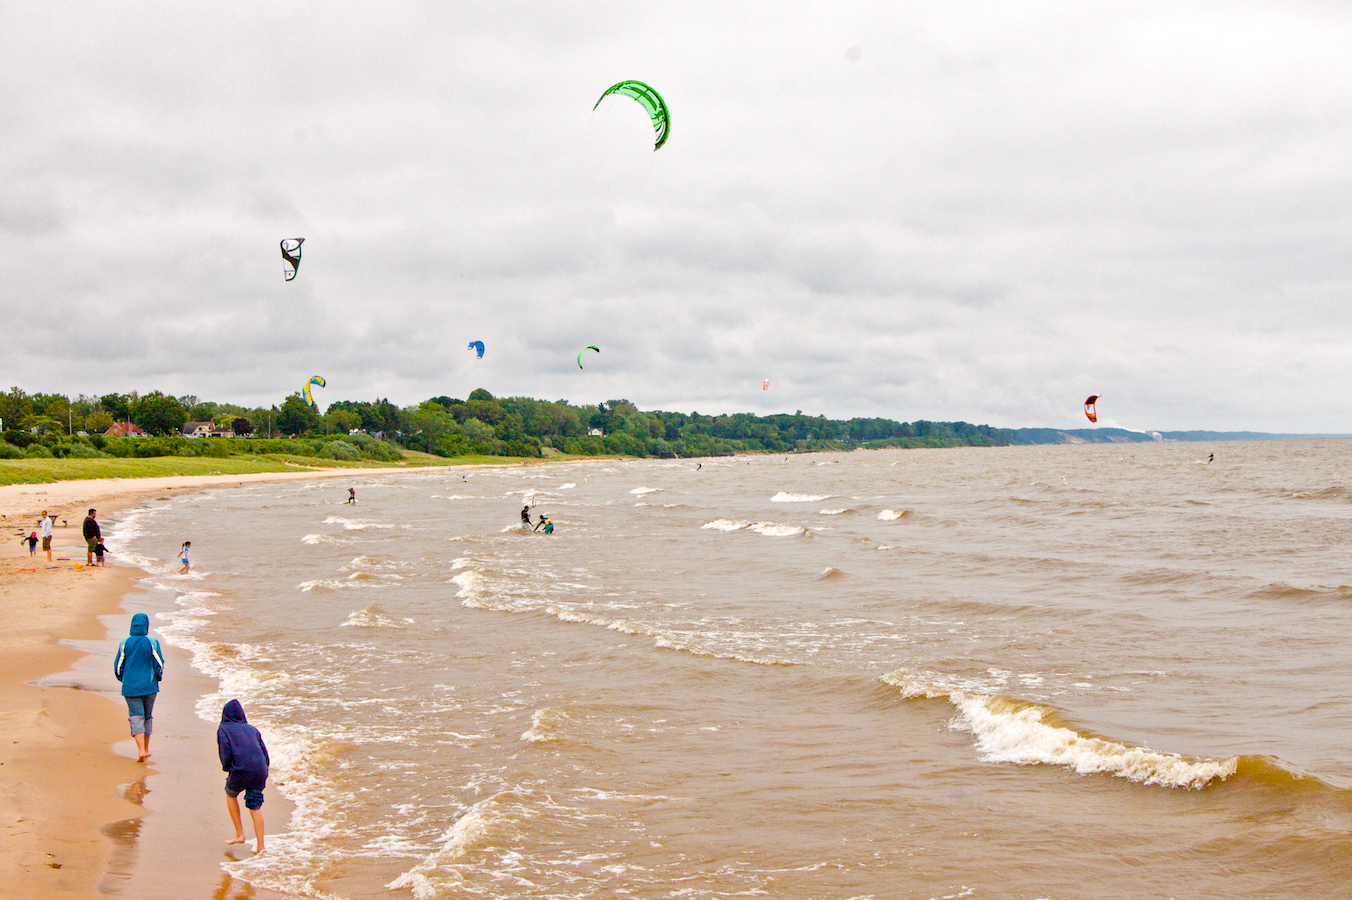

In [96]:
Image.fromarray(original_image)

In [ ]:
## Exercise: Tuning the cls_confidence, nms_threshold to affect the inference result

In [101]:
cls_confidence = 0.3
nms_threshold = 0.45

pred_bbox = model.predict(image_data)
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, cls_confidence)
bboxes = utils.nms(bboxes, nms_threshold, method='nms')

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = utils.draw_bbox(original_image, bboxes)
image = Image.fromarray(image)

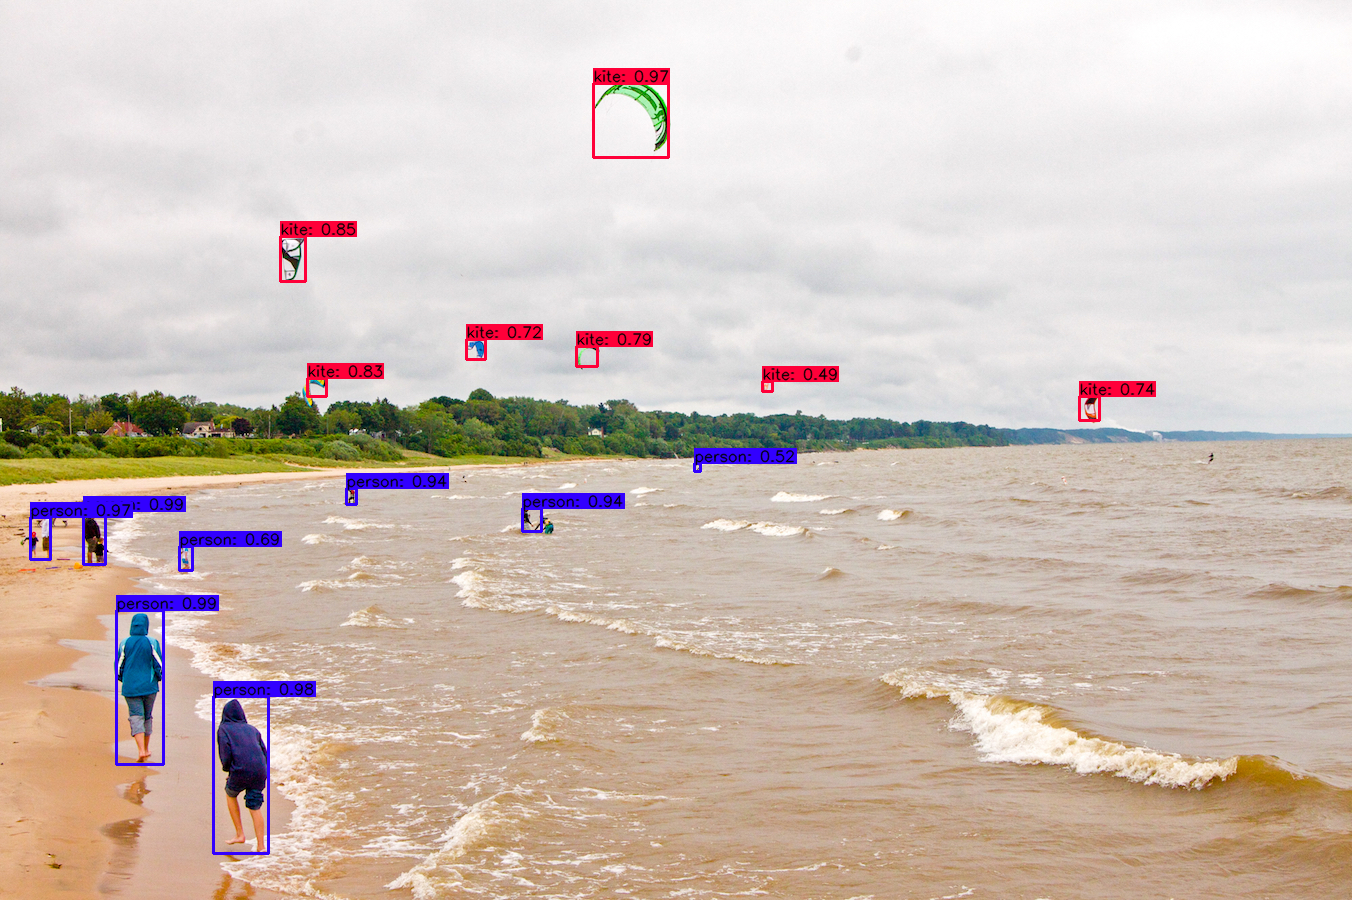

In [102]:
image

In [ ]:
## Exercise: What's the meaning of the values in the predicted box?
## [Optional question]: What's the sum of all class probablities? 

In [29]:
pred_bbox = model.predict(image_data)

In [41]:
for i in range(3):
    print(pred_bbox[i].shape)

(1, 52, 52, 3, 85)
(1, 26, 26, 3, 85)
(1, 13, 13, 3, 85)


In [76]:
print(pred_bbox[0][0,29,35,2,:4])
print(pred_bbox[0][0,29,35,2,4])
print(pred_bbox[0][0,29,35,2,5:])

[285.63168  238.03645   44.526516  28.178974]
0.99765605
[1.48266554e-04 3.36766243e-06 9.97580886e-01 3.26633453e-05
 3.27825546e-07 9.83476639e-06 6.25848770e-07 1.65259838e-03
 4.52995300e-06 2.08616257e-07 3.51667404e-06 1.87754631e-06
 1.04904175e-05 3.27825546e-07 3.27825546e-07 8.94069672e-08
 3.57627869e-07 3.57627869e-07 2.38418579e-07 2.59280205e-06
 2.98023224e-08 2.98023224e-07 3.57627869e-07 1.19209290e-07
 7.06315041e-06 3.03983688e-06 3.63588333e-06 2.98023224e-08
 6.25848770e-07 6.25848770e-07 2.08616257e-07 1.49011612e-07
 4.76837158e-07 8.34465027e-07 3.57627869e-07 1.78813934e-07
 1.72853470e-06 4.76837158e-07 2.38418579e-07 3.57627869e-07
 2.38418579e-07 2.68220901e-07 0.00000000e+00 5.96046448e-08
 2.98023224e-08 1.34110451e-06 8.94069672e-08 1.19209290e-07
 2.98023224e-08 2.98023224e-08 0.00000000e+00 0.00000000e+00
 2.98023224e-07 2.98023224e-08 9.23871994e-07 1.19209290e-07
 5.96046448e-08 5.96046448e-08 4.17232513e-07 5.96046448e-08
 2.98023224e-08 4.76837158e-

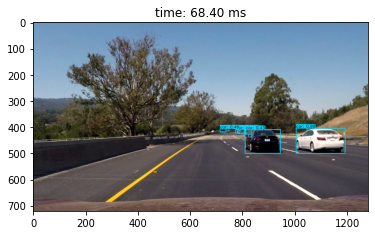

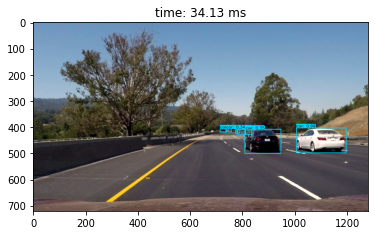

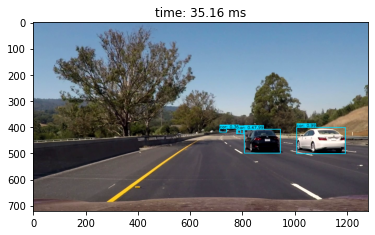

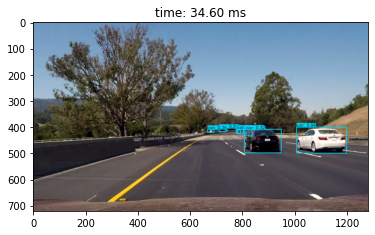

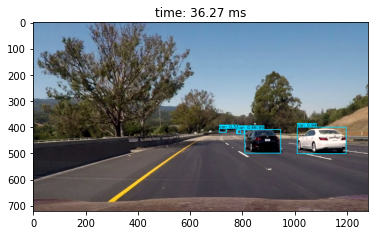

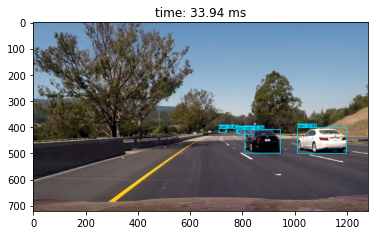

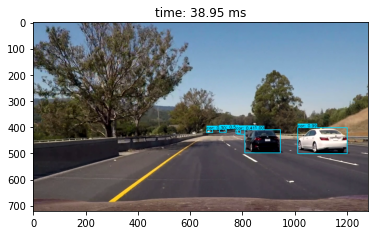

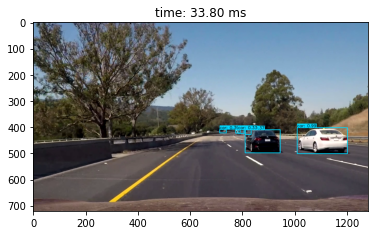

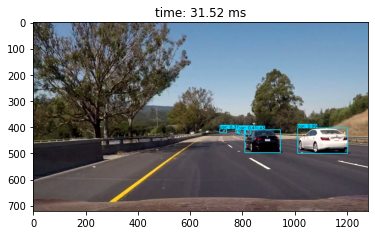

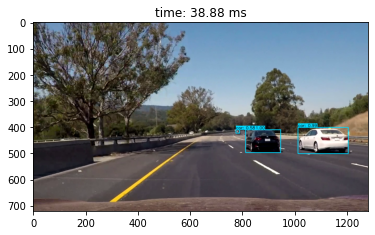

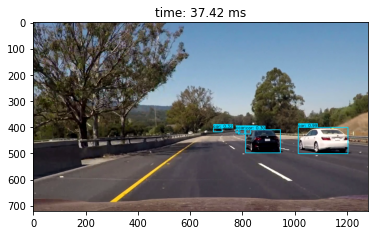

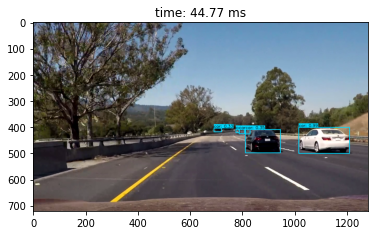

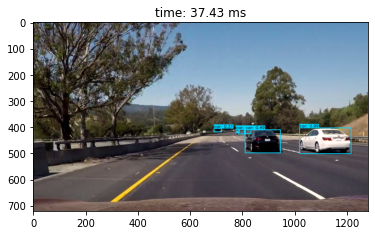

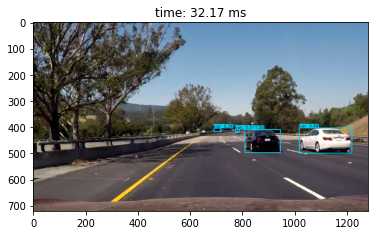

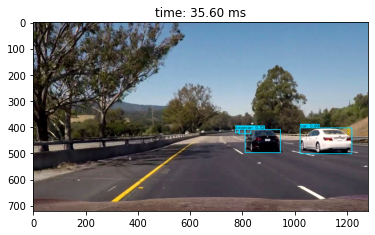

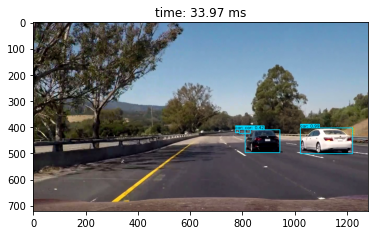

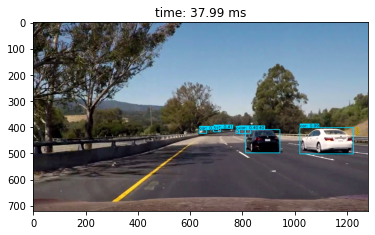

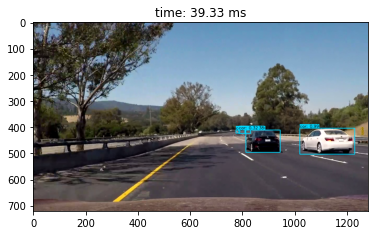

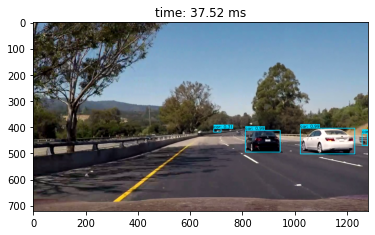

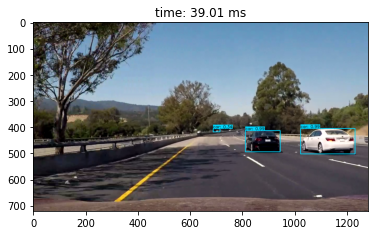

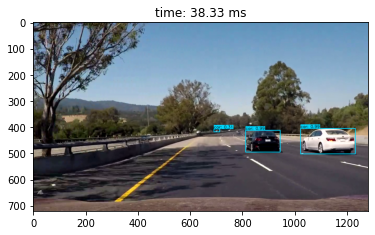

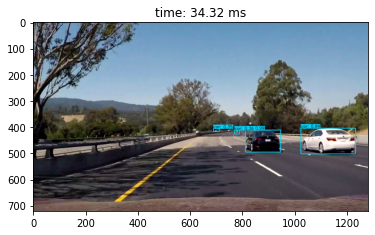

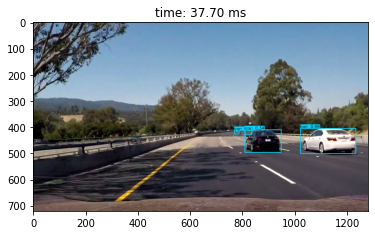

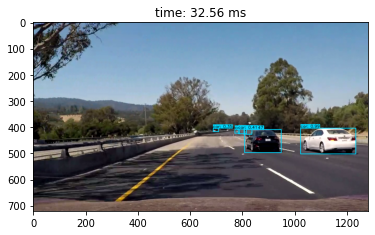

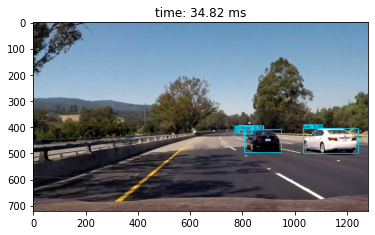

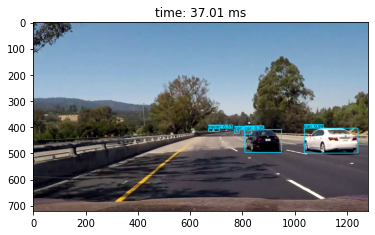

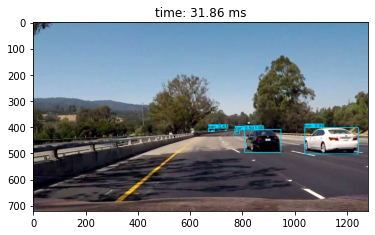

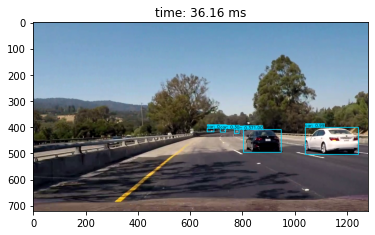

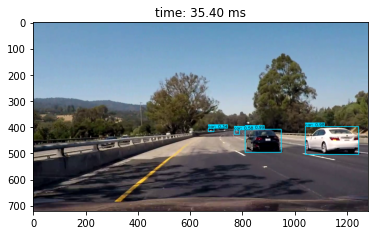

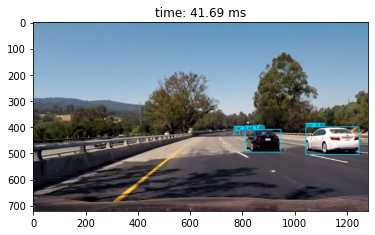

In [22]:
import time
import matplotlib.pyplot as plt

video_path      = "./docs/road.mp4"

num_classes     = 80
input_size      = 416

vid = cv2.VideoCapture(video_path)
for _ in range(30):
    return_value, frame = vid.read()
    if return_value:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("No image!")
    frame_size = frame.shape[:2]
    image_data = utils.image_preporcess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)

    prev_time = time.time()
    pred_bbox = model.predict_on_batch(image_data)
    curr_time = time.time()
    exec_time = curr_time - prev_time

    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes = utils.postprocess_boxes(pred_bbox, frame_size, input_size, 0.3)
    bboxes = utils.nms(bboxes, 0.45, method='nms')
    image = utils.draw_bbox(frame, bboxes)

    result = np.asarray(image)
    info = "time: %.2f ms" %(1000*exec_time)
    plt.title(info)
    plt.imshow(result)
    plt.show()